In [2]:
import os, re, sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

In [8]:
%%time
### Kudos to Ottokyu (https://twitter.com/ottokyu) creator of https://sgwuhan.xose.net/ for making the data available
! python getDataFromSgWuhan.py

CPU times: user 194 ms, sys: 65.1 ms, total: 259 ms
Wall time: 11.4 s


In [9]:
d = {'Jan 23':1,'Jan 24':2,'Jan 25':0,'Jan 26':1,'Jan 27':1, 'Jan 28':2,'Jan 29':3,'Jan 30':2,'Jan 31':4,'Feb 1':2,\
           'Feb 2': 0, 'Feb 3': 0, 'Feb 4': 6, 'Feb 5':4, 'Feb 6': 2, 'Feb 7': 4, 'Feb 8':7, 'Feb 9': 3, 'Feb 10': 2, \
          'Feb 11': 2, 'Feb 12': 2, 'Feb 13': 8, 'Feb 14': 9, 'Feb 15': 2}
r = {'Feb 4':1,'Feb 7':1,'Feb 9':4,'Feb 10':1,'Feb 11':2,'Feb 12': 6,'Feb 14': 2, 'Feb 15':1}

In [31]:
inf = pd.DataFrame.from_dict(d,orient='index',columns=['count']).reset_index()
inf.columns = ['Date','Infected']

In [32]:
rec = pd.DataFrame.from_dict(r,orient='index',columns=['count']).reset_index()
rec.columns = ['Date','Recovered']

In [37]:
total = pd.merge(inf,rec,on='Date', how='left')

In [38]:
total['Recovered'].fillna(0, inplace=True)

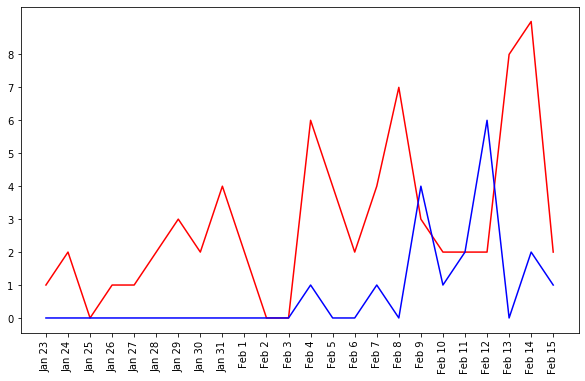

In [53]:
fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(rotation=90)
plt.yticks(list(range(inf['Infected'].max())))
ax.plot(total['Date'], total['Infected'], color='r')
ax.plot(total['Date'], total['Recovered'], color='b')
plt.show()

## SEIR model
- to overlay

In [189]:
incubation_duration = 8
infectious_duration = 14

beta = 0.3
sigma = 1/incubation_duration # incubation rate
gamma = 1/infectious_duration # recovery rate

In [202]:
N = 500000   # Total population as an arbituary number, putting it as the size of Singapore's population
I0, R0 = 1, 0 # Initial number of Infected (base on first case of Wuhan infection) and Recovered cases
E0 = 5 # initial number of Exposed cases
S0 = N - E0 - I0 - R0 # initial susceptible population

In [203]:
## to simulate over the next n days
n_days = 360
t = np.linspace(0, n_days, n_days)

In [204]:
def deriv(y, t, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E 
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [205]:
from scipy.integrate import odeint

# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SEIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, sigma, gamma))
S, E, I, R = ret.T

In [206]:
from datetime import datetime

date_start = datetime.strptime('2020-01-23', '%Y-%m-%d')
datelist = pd.date_range(date_start,periods=n_days).to_list()
dates = [str(d.date()) for d in datelist]

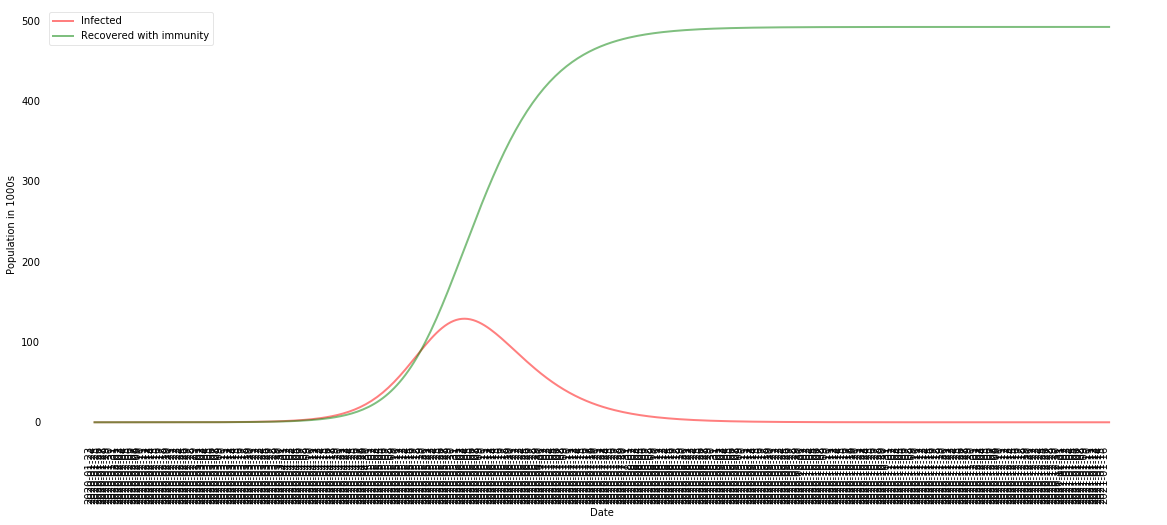

In [212]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot()
# ax.plot(dates, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
# ax.plot(dates, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(dates, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(dates, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

ax.set_xticklabels(dates, rotation = 90, ha="right")
ax.set_xticks(range(n_days),5)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('Date')
ax.set_ylabel(f'Population in {1000}s')
# ax.set_ylim(0,N+0.2*N)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [208]:
dates[I.argmax()]

'2020-06-02'

In [209]:
total['Infected_Simulated'] = np.round(I[:len(d)])
total['Recovered_Simulated'] = np.round(R[:len(d)])

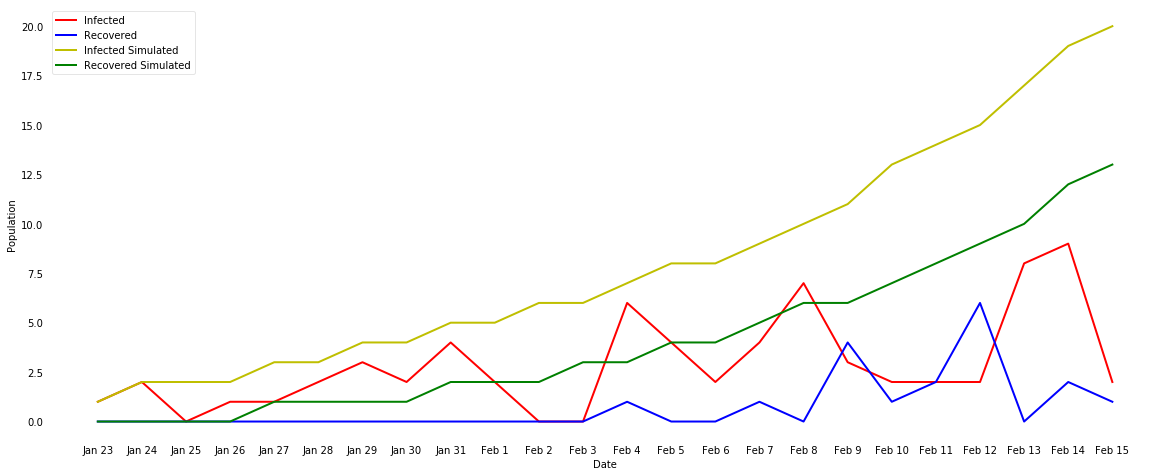

In [210]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot()
ax.plot(total['Date'], total['Infected'], lw=2, label='Infected', color='r')
ax.plot(total['Date'], total['Recovered'], lw=2, label='Recovered', color='b')
ax.plot(total['Date'], total['Infected_Simulated'], lw=2, label='Infected Simulated', color='y')
ax.plot(total['Date'], total['Recovered_Simulated'], lw=2, label='Recovered Simulated', color='g')

# ax.plot(dates, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

ax.set_xticks(range(len(d)),2)
# ax.set_xticklabels(dates, rotation = 30, ha="right")
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('Date')
ax.set_ylabel(f'Population')
# ax.set_ylim(0,N+0.2*N)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()